In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

## Bottrell
https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/MNRAS/486/390

## Yang07

In [2]:
grps = Table.read("./data/group_DR7/modelA_group", format = 'ascii')

In [3]:
mask_m = (grps['col7'] > np.log10(2e12))
mask_z = (grps['col4'] > 0.015) & (grps['col4'] < 0.055)
mask_coord = ((grps['col2'] < 50) | (grps['col2'] > 300)) & ((grps['col3'] < 5) & (grps['col3'] > -5))
mask_grp = mask_m & mask_z & mask_coord

In [4]:
grps = grps[mask_grp]

In [5]:
ra_grp = grps['col2']
# mask_ra = grps['col2'] > 300
# ra_grp[mask_ra] = ra_grp[mask_ra] - 360

dec_grp = grps['col3']

In [6]:
zz_grp = grps['col4']
dist_grp = cosmo.comoving_distance(zz_grp).value # Mpc

In [7]:
coords = SkyCoord(ra = ra_grp * u.degree, dec = dec_grp * u.degree, distance = dist_grp * u.Mpc)

In [8]:
x_grp = coords.cartesian.x
y_grp = coords.cartesian.y
z_grp = coords.cartesian.z

# Calculate

In [9]:
# from scipy.sparse.csgraph import minimum_spanning_tree
# from sklearn.neighbors import kneighbors_graph

from utils.utils import construct_mst, get_graph_degree, get_branch_index, get_branch_end_index

In [193]:
k_neighbours=20
number_of_nodes = len(x_grp)

edge_length, edge_x, edge_y, edge_z, edge_index = construct_mst(x_grp, y_grp, z_grp, k_neighbours)
degree = get_graph_degree(edge_index, number_of_nodes)

index1, index2 = edge_index[0], edge_index[1]
edge_degree = np.array([degree[index1], degree[index2]])

branch_index, rejected_branch_index = get_branch_index(edge_index, edge_degree)

branch_length = [np.sum(edge_length[i]) for i in branch_index]
branch_length = np.array(branch_length)

branch_index_end = get_branch_end_index(edge_index, edge_degree, branch_index)
branch_index_end1, branch_index_end2 = branch_index_end[0], branch_index_end[1]

dx = abs(x_grp[branch_index_end1] - x_grp[branch_index_end2])
dy = abs(y_grp[branch_index_end1] - y_grp[branch_index_end2])
dz = abs(z_grp[branch_index_end1] - z_grp[branch_index_end2])
branch_end_length = np.sqrt((dx ** 2.) + (dy ** 2.) + (dz ** 2.))

branch_shape = branch_end_length/branch_length

# Visualization

In [11]:
theta_grp = ra_grp * np.pi / 180

Text(0, 0.5, 'RA [deg]')

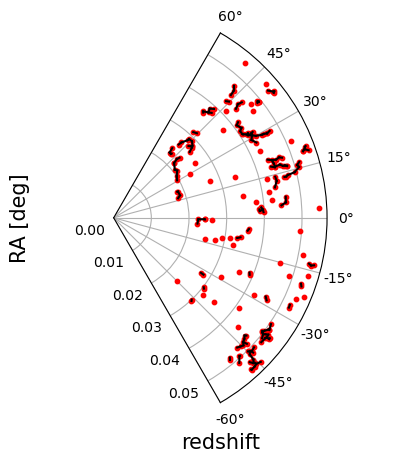

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

mask_link = edge_length < 5.75 / 0.7
ax.scatter(theta_grp, zz_grp, s = 10, zorder = 2, color = 'r')

ax.plot([theta_grp[edge_index[0][mask_link]], theta_grp[edge_index[1][mask_link]]],
        [zz_grp[edge_index[0][mask_link]], zz_grp[edge_index[1][mask_link]]],
         color = 'k' )

ax.set_thetalim(-np.pi/3, np.pi/3)

ax.set_xlabel('redshift', fontsize = 15)
ax.set_ylabel('RA [deg]', fontsize = 15)

# fig.savefig('result.png')

# Comic Web Indentification

In [17]:
cat = Table.read("./data/s82grfn.fit")

In [29]:
ra_gal = cat['_RAJ2000'].value
dec_gal = cat['_DEJ2000'].value
zz_gal = cat['z'].value

dist_gal = cosmo.comoving_distance(zz_gal).value # Mpc

coords_gal = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree, distance = dist_gal * u.Mpc)

x_gal = coords_gal.cartesian.x
y_gal = coords_gal.cartesian.y
z_gal = coords_gal.cartesian.z

### 1. Cluster

In [38]:
from scipy import spatial

In [119]:
tree = spatial.cKDTree(np.array([x_grp, y_grp, z_grp]).T)

In [120]:
d_node = tree.query(np.array([x_gal, y_gal, z_gal]).T, k = 2)

In [87]:
mask_cluster = (d_node[0][:, 0] < 1 / 0.7)

### 2. Filament

In [135]:
grp_index = np.where(mask_link)[0]

mask_cand1 = np.isin(d_node[1][:, 0], grp_index)
mask_cand2 = np.isin(d_node[1][:, 1], grp_index)
mask_cand = mask_cand1 & mask_cand2

In [125]:
# mask_node1 = edge_index[0][mask_link]
# mask_node2 = edge_index[1][mask_link]

P1 = np.array([x_grp[d_node[1][:, 0]], y_grp[d_node[1][:, 0]], z_grp[d_node[1][:, 0]]]).T
P2 = np.array([x_grp[d_node[1][:, 1]], y_grp[d_node[1][:, 1]], z_grp[d_node[1][:, 1]]]).T

Pgal = np.array([x_gal, y_gal, z_gal]).T


In [154]:
d_fil = np.linalg.norm(
    np.cross(P2 - Pgal, P1 - Pgal)
    , axis = 1) / np.linalg.norm(P2 - P1, axis = 1) 

In [156]:
mask_filament = mask_cand & ~mask_cluster & (d_fil < 4.12 / 0.7)

### 3. Tendrils

In [342]:
k_neighbours=20
mask_remain = (~mask_filament & ~mask_cluster).copy()
number_of_nodes_t = len(x_gal[mask_remain])

edge_length_t, edge_x_t, edge_y_t, edge_z_t, edge_index_t = construct_mst(x_gal[mask_remain], y_gal[mask_remain], z_gal[mask_remain], k_neighbours)
degree_t = get_graph_degree(edge_index_t, number_of_nodes_t)

index1, index2 = edge_index_t[0], edge_index_t[1]
edge_degree_t = np.array([degree_t[index1], degree_t[index2]])

branch_index_t, rejected_branch_index_t = get_branch_index(edge_index_t, edge_degree_t)

branch_length_t = [np.sum(edge_length_t[i]) for i in branch_index_t]
branch_length_t = np.array(branch_length_t)

branch_index_end_t = get_branch_end_index(edge_index_t, edge_degree_t, branch_index_t)
branch_index_end1_t, branch_index_end2_t = branch_index_end_t[0], branch_index_end_t[1]

dx_t = abs(x_gal[branch_index_end1_t] - x_gal[branch_index_end2_t])
dy_t = abs(y_gal[branch_index_end1_t] - y_gal[branch_index_end2_t])
dz_t = abs(z_gal[branch_index_end1_t] - z_gal[branch_index_end2_t])
branch_end_length_t = np.sqrt((dx_t ** 2.) + (dy_t ** 2.) + (dz_t ** 2.))

branch_shape_t = branch_end_length_t/branch_length_t

x_gal[mask_remain].shape, 

In [343]:
mask_link_t = edge_length_t < 3.0 / 0.7 # flag for mask_remain
mask_tendril = np.zeros(shape = len(mask_cluster), dtype = bool)

# mask_tendril[mask_remain][edge_index_t[0][mask_link_t]] = 1.
# mask_tendril[mask_remain][edge_index_t[1][mask_link_t]] = 1.

# mask_tendril[mask_cluster] = False
# mask_tendril[mask_filament] = False

In [349]:
# np.where(mask_remain)[0][edge_index_t[0][mask_link_t]]

# np.where(mask_remain)[0].shape
edge_index_t.shape, edge_length_t.shape, mask_tendril[~mask_remain].shape

((2, 15234), (15234,), (1496,))

In [330]:
mask_tendril[mask_remain] = True
mask_tendril[~mask_remain][0] 
mask_tendril[~mask_remain][0] = True
mask_tendril[~mask_remain][0]

False

In [234]:
# sum(mask_tendril)

# edge_index_t
sum(mask_filament | mask_cluster), sum(mask_tendril)


(1496, 0)

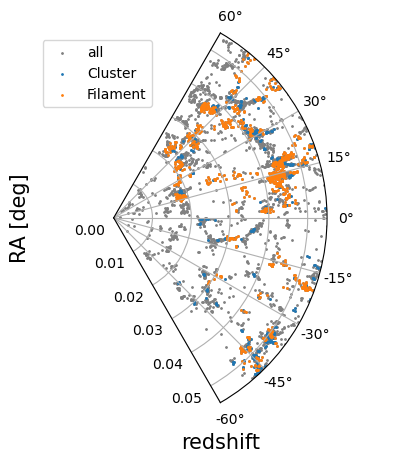

In [224]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

mask_link = edge_length < 5.75 / 0.7
# ax.scatter(theta_grp, zz_grp, s = 10, zorder = 2, color = 'r', alpha = .2)
theta_gal = ra_gal * np.pi / 180

ax.scatter(theta_gal, zz_gal, s = 1, label = 'all', color = 'gray')
ax.scatter(theta_gal[mask_cluster], zz_gal[mask_cluster], s = 1, label = 'Cluster')
ax.scatter(theta_gal[mask_filament], zz_gal[mask_filament], s = 1, label = 'Filament')
# ax.scatter(theta_gal[mask_tendril], zz_gal[mask_tendril], s = 1, label = 'Tendril')


ax.set_thetalim(-np.pi/3, np.pi/3)
ax.set_rlim(0, 0.055)

ax.set_xlabel('redshift', fontsize = 15)
ax.set_ylabel('RA [deg]', fontsize = 15)

ax.legend()
